# Model Training  

Using device: cuda


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25 - Train Loss: 0.8439, Val Loss: 1.1368, Train Acc: 0.6410, Val Acc: 0.4715
Epoch 2/25 - Train Loss: 0.5669, Val Loss: 1.3700, Train Acc: 0.7607, Val Acc: 0.5633
Epoch 3/25 - Train Loss: 0.4091, Val Loss: 0.5409, Train Acc: 0.8400, Val Acc: 0.8122
Epoch 4/25 - Train Loss: 0.3091, Val Loss: 0.3890, Train Acc: 0.8818, Val Acc: 0.8428
Epoch 5/25 - Train Loss: 0.1819, Val Loss: 0.1698, Train Acc: 0.9349, Val Acc: 0.9473
Epoch 6/25 - Train Loss: 0.1062, Val Loss: 0.1608, Train Acc: 0.9634, Val Acc: 0.9241
Epoch 7/25 - Train Loss: 0.0839, Val Loss: 0.3142, Train Acc: 0.9715, Val Acc: 0.9114
Epoch 8/25 - Train Loss: 0.0909, Val Loss: 0.2082, Train Acc: 0.9700, Val Acc: 0.9283
Epoch 9/25 - Train Loss: 0.0678, Val Loss: 0.1709, Train Acc: 0.9776, Val Acc: 0.9631
Epoch 10/25 - Train Loss: 0.0323, Val Loss: 0.1310, Train Acc: 0.9898, Val Acc: 0.9694
Epoch 11/25 - Train Loss: 0.0060, Val Loss: 0.2250, Train Acc: 0.9982, Val Acc: 0.9599
Epoch 12/25 - Train Loss: 0.0691, Val Loss: 0.2445, 

/tmp/ipykernel_30/4148995784.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


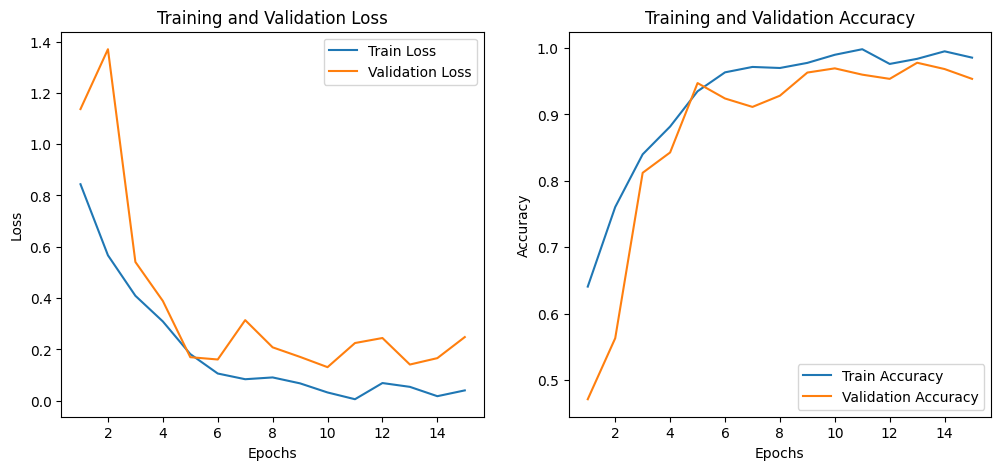

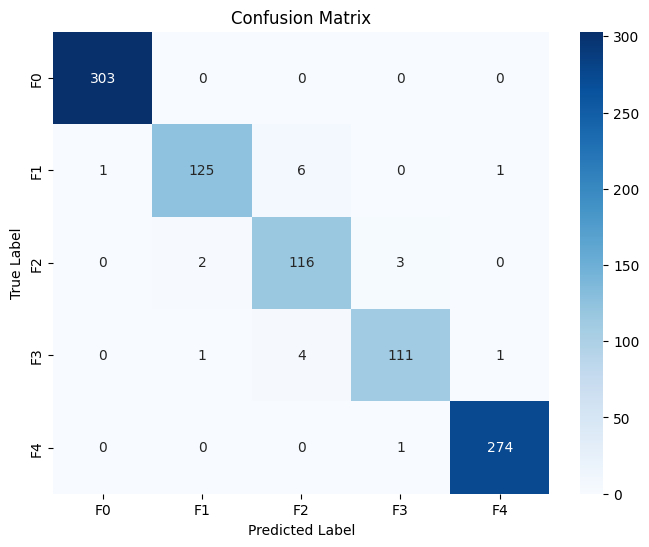

              precision    recall  f1-score   support

          F0       1.00      1.00      1.00       303
          F1       0.98      0.94      0.96       133
          F2       0.92      0.96      0.94       121
          F3       0.97      0.95      0.96       117
          F4       0.99      1.00      0.99       275

    accuracy                           0.98       949
   macro avg       0.97      0.97      0.97       949
weighted avg       0.98      0.98      0.98       949



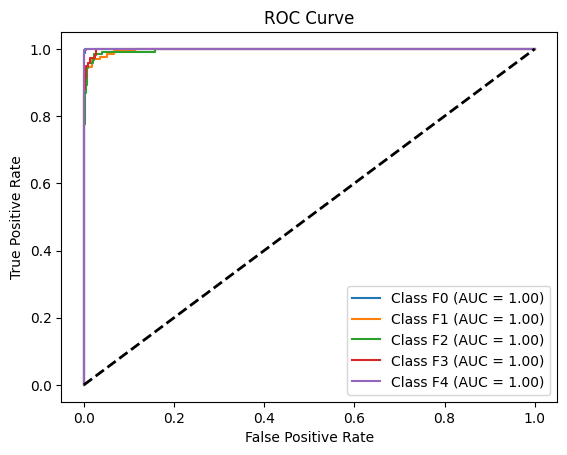

Training Complete. Model evaluation and plots generated.


In [2]:
# Imports
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
DATASET_PATH = "/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset"

# Hyperparameters
BATCH_SIZE = 16
EPOCHS = 25
LEARNING_RATE = 1e-3
PATIENCE = 5

# Data Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load Dataset
full_dataset = datasets.ImageFolder(DATASET_PATH, transform=data_transforms['train'])

# Split dataset
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

val_dataset.dataset.transform = data_transforms['val_test']
test_dataset.dataset.transform = data_transforms['val_test']

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Class labels
class_names = full_dataset.classes
num_classes = len(class_names)

# Model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Early stopping parameters
best_val_loss = float('inf')
patience_counter = 0

# Training and Validation Loop
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss, correct_train = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_train += torch.sum(preds == labels)

    train_loss /= len(train_loader)
    train_accuracy = correct_train.double() / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy.item())

    # Validation
    model.eval()
    val_loss, correct_val = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_val += torch.sum(preds == labels)

    val_loss /= len(val_loader)
    val_accuracy = correct_val.double() / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy.item())

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

# Plot Training and Validation Metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Evaluation on Test Set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix with Counts
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=class_names))

# ROC Curve
all_probs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = torch.softmax(model(inputs), dim=1)
        all_probs.extend(outputs.cpu().numpy())

all_labels_onehot = np.eye(num_classes)[all_labels]
fpr, tpr, roc_auc = {}, {}, {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_onehot[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

print("Training Complete. Model evaluation and plots generated.")


# Evaluating the model


/tmp/ipykernel_30/1276091248.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Loss: 0.0894, Test Accuracy: 0.9789

Classification Report:
              precision    recall  f1-score   support

          F0       1.00      1.00      1.00       303
          F1       0.98      0.94      0.96       133
          F2       0.92      0.96      0.94       121
          F3       0.97      0.95      0.96       117
          F4       0.99      1.00      0.99       275

    accuracy                           0.98       949
   macro avg       0.97      0.97      0.97       949
weighted avg       0.98      0.98      0.98       949



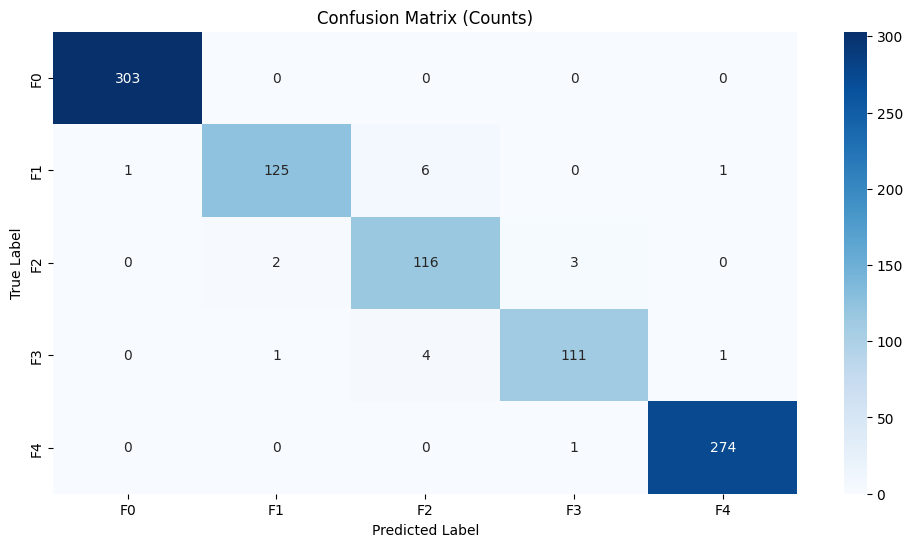

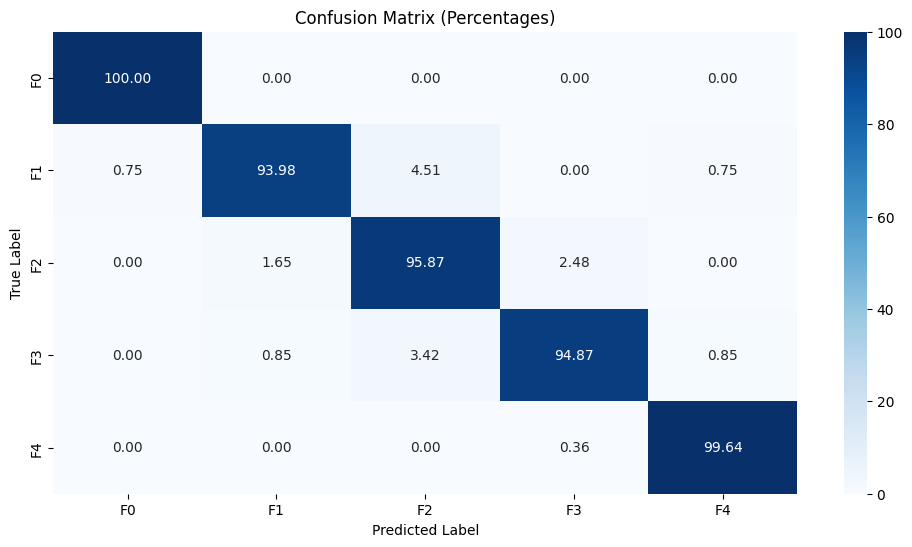

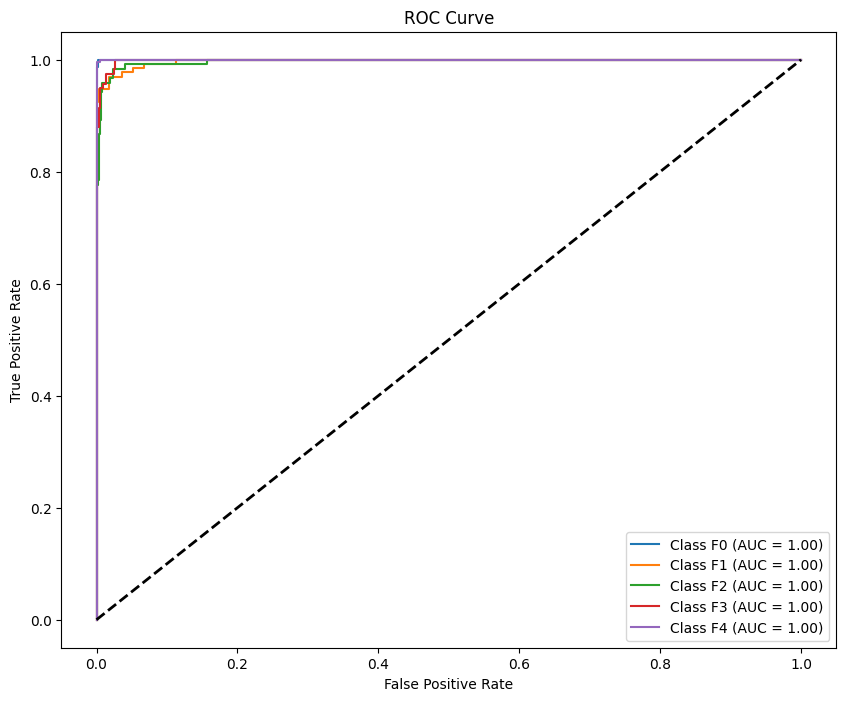

In [3]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best model weights
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Evaluation Metrics
test_loss = 0
correct = 0
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Predictions and probabilities
        preds = torch.argmax(outputs, dim=1)
        probs = torch.softmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_loss /= len(test_loader)
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix with Percentages
cm = confusion_matrix(all_labels, all_preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Counts)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Percentages)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# ROC Curve and AUC
all_labels_onehot = np.eye(num_classes)[all_labels]
fpr, tpr, roc_auc = {}, {}, {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_onehot[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC Curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
